# Vehicle Detection and Tracking
- Build a classifier that can detect vehicles in video frames
- Apply HOG feature extraction techniques to the pipeline
- Demostrate how to use heatmaps to remove false positives
- Use the pipeline to draw bounding boxes in the project video

### Load Data

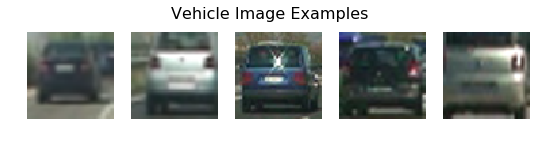

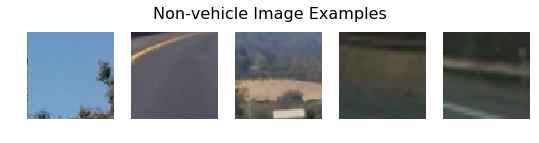

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

vehicles = glob.glob("./vehicles/*/*.png")
non_vehicles = glob.glob("./non-vehicles/*/*.png")

# Show a few examples
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(9, 2))
fig1.suptitle("Vehicle Image Examples", fontsize=16)
ax1.imshow(mpimg.imread(vehicles[0]))
ax1.axis("off")
ax2.imshow(mpimg.imread(vehicles[100]))
ax2.axis("off")
ax3.imshow(mpimg.imread(vehicles[200]))
ax3.axis("off")
ax4.imshow(mpimg.imread(vehicles[300]))
ax4.axis("off")
ax5.imshow(mpimg.imread(vehicles[400]))
ax5.axis("off")
plt.savefig("./output_images/vehicles.jpg")

fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(9, 2))
fig2.suptitle("Non-vehicle Image Examples", fontsize=16)
ax1.imshow(mpimg.imread(non_vehicles[0]))
ax1.axis("off")
ax2.imshow(mpimg.imread(non_vehicles[100]))
ax2.axis("off")
ax3.imshow(mpimg.imread(non_vehicles[200]))
ax3.axis("off")
ax4.imshow(mpimg.imread(non_vehicles[-300]))
ax4.axis("off")
ax5.imshow(mpimg.imread(non_vehicles[-400]))
ax5.axis("off")
plt.savefig("./output_images/non_vehicles.jpg")
plt.show()

### Extract Features

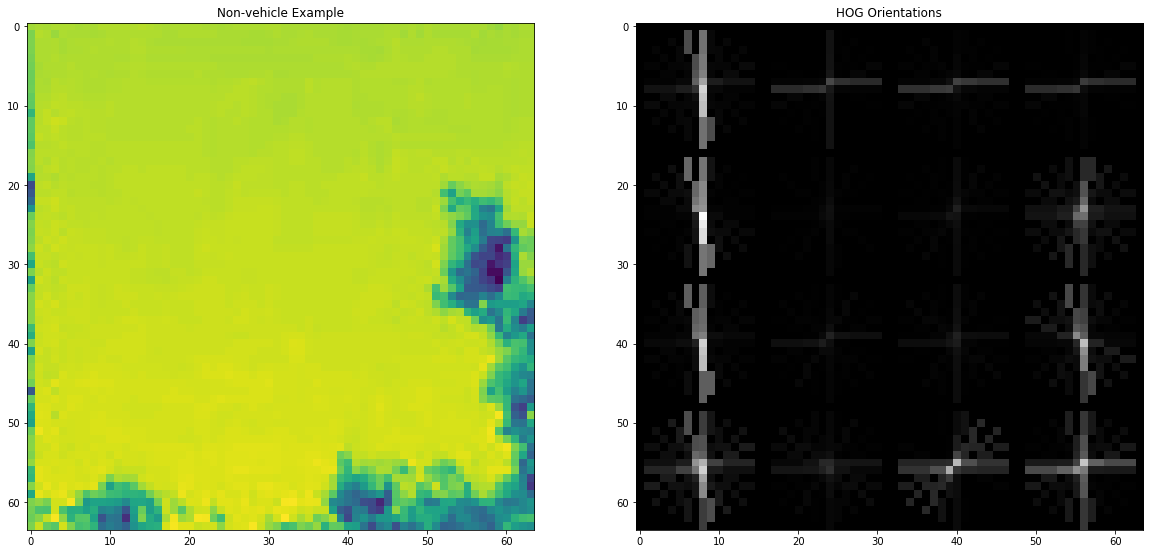

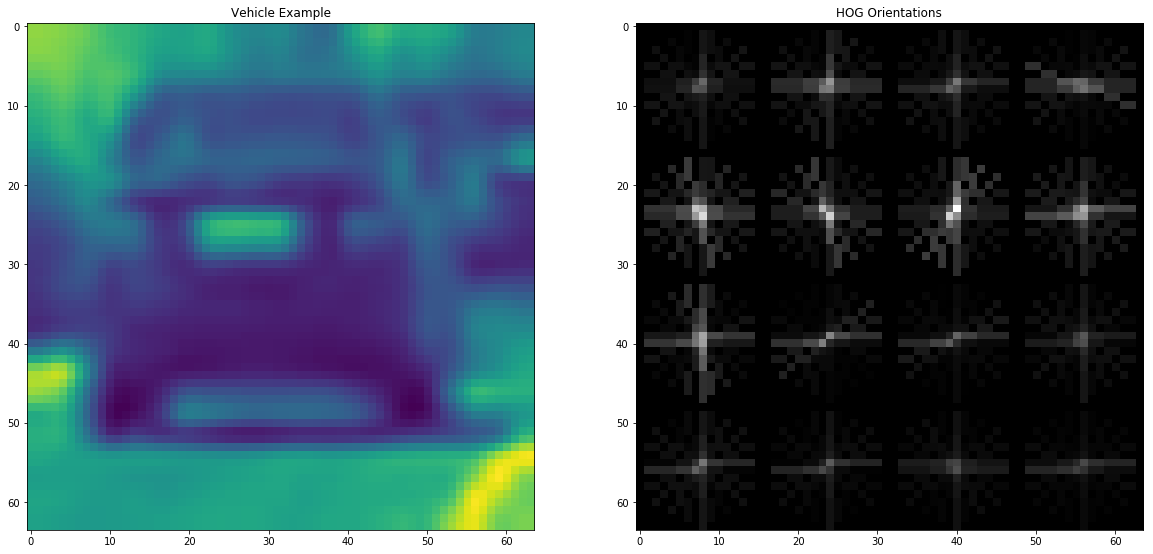

In [30]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Visualization
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    
    # no histogram visualization
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

img = mpimg.imread(non_vehicles[0])
img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
features, hog_img = get_hog_features(img[:, :, 1], orient=11, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
ax1.imshow(img[:, :, 0])
ax1.set_title('Non-vehicle Example')
ax2.imshow(hog_img, cmap="gray")
ax2.set_title('HOG Orientations')
plt.savefig("./output_images/non_vehicle_hog.jpg")

img = mpimg.imread(vehicles[0])
img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
features, hog_img = get_hog_features(img[:, :, 1], orient=11, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
ax1.imshow(img[:, :, 0])
ax1.set_title('Vehicle Example')
ax2.imshow(hog_img, cmap="gray")
ax2.set_title('HOG Orientations')
plt.savefig("./output_images/vehicle_hog.jpg")

### Classifier

In [3]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.externals import joblib

# To use multiprocessing, put this if statement
if __name__ == "__main__":
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    print("Extracting HOG features...")
    t=time.time()
    # Extract features
    car_features = extract_features(vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(non_vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Normalize the data
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    joblib.dump(X_scaler, 'scaler.pkl')
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Shuffle and split data
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, n_jobs=-1)
    print("Training the SVC...")
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    # Save the model
    joblib.dump(clf, 'classifier.pkl')

    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Extracting HOG features...


D:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


59.27 Seconds to extract HOG features...
Training the SVC...
326.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9969
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
0.05265 Seconds to predict 10 labels with SVC


### Search and Classify

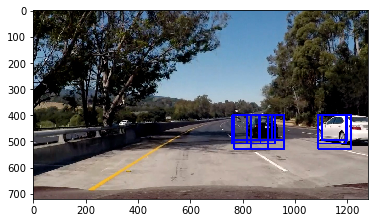

In [10]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.externals import joblib

clf = joblib.load('classifier.pkl') # Load saved model
X_scaler = joblib.load('scaler.pkl')
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    for sc in scale:
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

        if sc != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/sc), np.int(imshape[0]/sc)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                test_prediction = clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*sc)
                    ytop_draw = np.int(ytop*sc)
                    win_draw = np.int(window*sc)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                    
                    bbox.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    
                
    return draw_img, bbox

ystart = 400
ystop = 656
scale = [1.5, 1.7, 2.0]
img = mpimg.imread("./test_images/test5.jpg")
out_img, boxlist = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imsave("./output_images/window_search.jpg", out_img)
plt.imshow(out_img)

### Remove False Positives

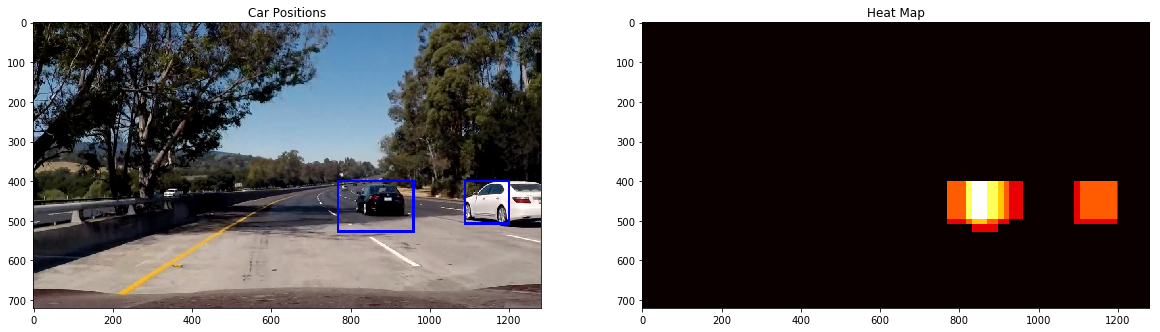

In [15]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, boxlist)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
ax1.imshow(draw_img)
ax1.set_title('Car Positions')
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map')
plt.imsave("./output_images/car_position.jpg", draw_img)
plt.imsave("./output_images/heat.jpg", heatmap, cmap="hot")

### Pipeline

In [8]:
# Overall pipeline for making videos
clf = joblib.load('classifier.pkl') # Load saved model
X_scaler = joblib.load('scaler.pkl')
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
ystart = 400
ystop = 656
scale = [1.5, 1.7, 2.0]
bbox_nframe = []
heat_nframe = []
nframe = 7

def pipeline(img):
    # find bounding boxes
    out_img, boxlist = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bbox_nframe.extend(boxlist)
    # Use Heatmap to reduce false positives
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_nframe[len(bbox_nframe)-nframe:]) # Use bounding boxes from last n frames
    heat = apply_threshold(heat, 1)
    heat_nframe.append(heat)
    n = len(heat_nframe)
    if n <= 7:
        temp = np.zeros_like(out_img[:,:,0]).astype(np.float)
        for h in heat_nframe:
            temp += h
        
    else:
        temp = np.zeros_like(out_img[:,:,0]).astype(np.float)
        for h in heat_nframe[n-nframe:]:
            temp += h
    
    temp[:, :200] = 0
    heatmap = np.clip(temp, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
    return draw_img

### Run the Pipeline and make a video

In [9]:
from moviepy.editor import VideoFileClip
bbox_nframe = []
heat_nframe = []
nframe = 7

output = "output.mp4"
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(pipeline)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [20:32<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 20min 32s
